<a href="https://colab.research.google.com/github/ShengChi-energytrack/Time-Series/blob/main/time_series_clustering_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install minisom

  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=a90e3af0eebba6bb5e3973ed93acdaf08fb4396800d53de89f2215c07bf557a5
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom


In [ ]:
pip install tslearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 6.3 MB/s eta 0:00:00


In [1]:
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shengchi","key":"6db2ab2ffcfbcbe748f2c6e2db0ee588"}'}

In [2]:
# install the opendatasets package
#!pip install opendatasets

import opendatasets as od

# download the dataset (this is a Kaggle dataset)
# during download you will be required to input your Kaggle username and password
od.download("https://www.kaggle.com/datasets/census/retail-and-retailers-sales-time-series-collection")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:Your Kaggle Key:Dataset URL: https://www.kaggle.com/datasets/census/retail-and-retailers-sales-time-series-collection


100%|██████████| 56.7k/56.7k [00:00<00:00, 459kB/s]

In [3]:
directory = 'retail-and-retailers-sales-time-series-collection/'

mySeries = []
namesofMySeries = []
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(directory+filename)
        df = df.loc[:,["date","value"]]
        # While we are at it I just filtered the columns that we will be working on
        df.set_index("date",inplace=True)
        # ,set the date columns as index
        df.sort_index(inplace=True)
        # and lastly, ordered the data according to our date index
        mySeries.append(df)
        namesofMySeries.append(filename[:-4])

There 23 time series data, and 333 (or 332) rows for each data

In [4]:
print(len(mySeries))

23


In [5]:
mySeries[1]

,value
date,
1992-01-01,146925
1992-02-01,147223
1992-03-01,146805
1992-04-01,148032
1992-05-01,149010
...,...
2019-05-01,454135
2019-06-01,455546
2019-07-01,458974


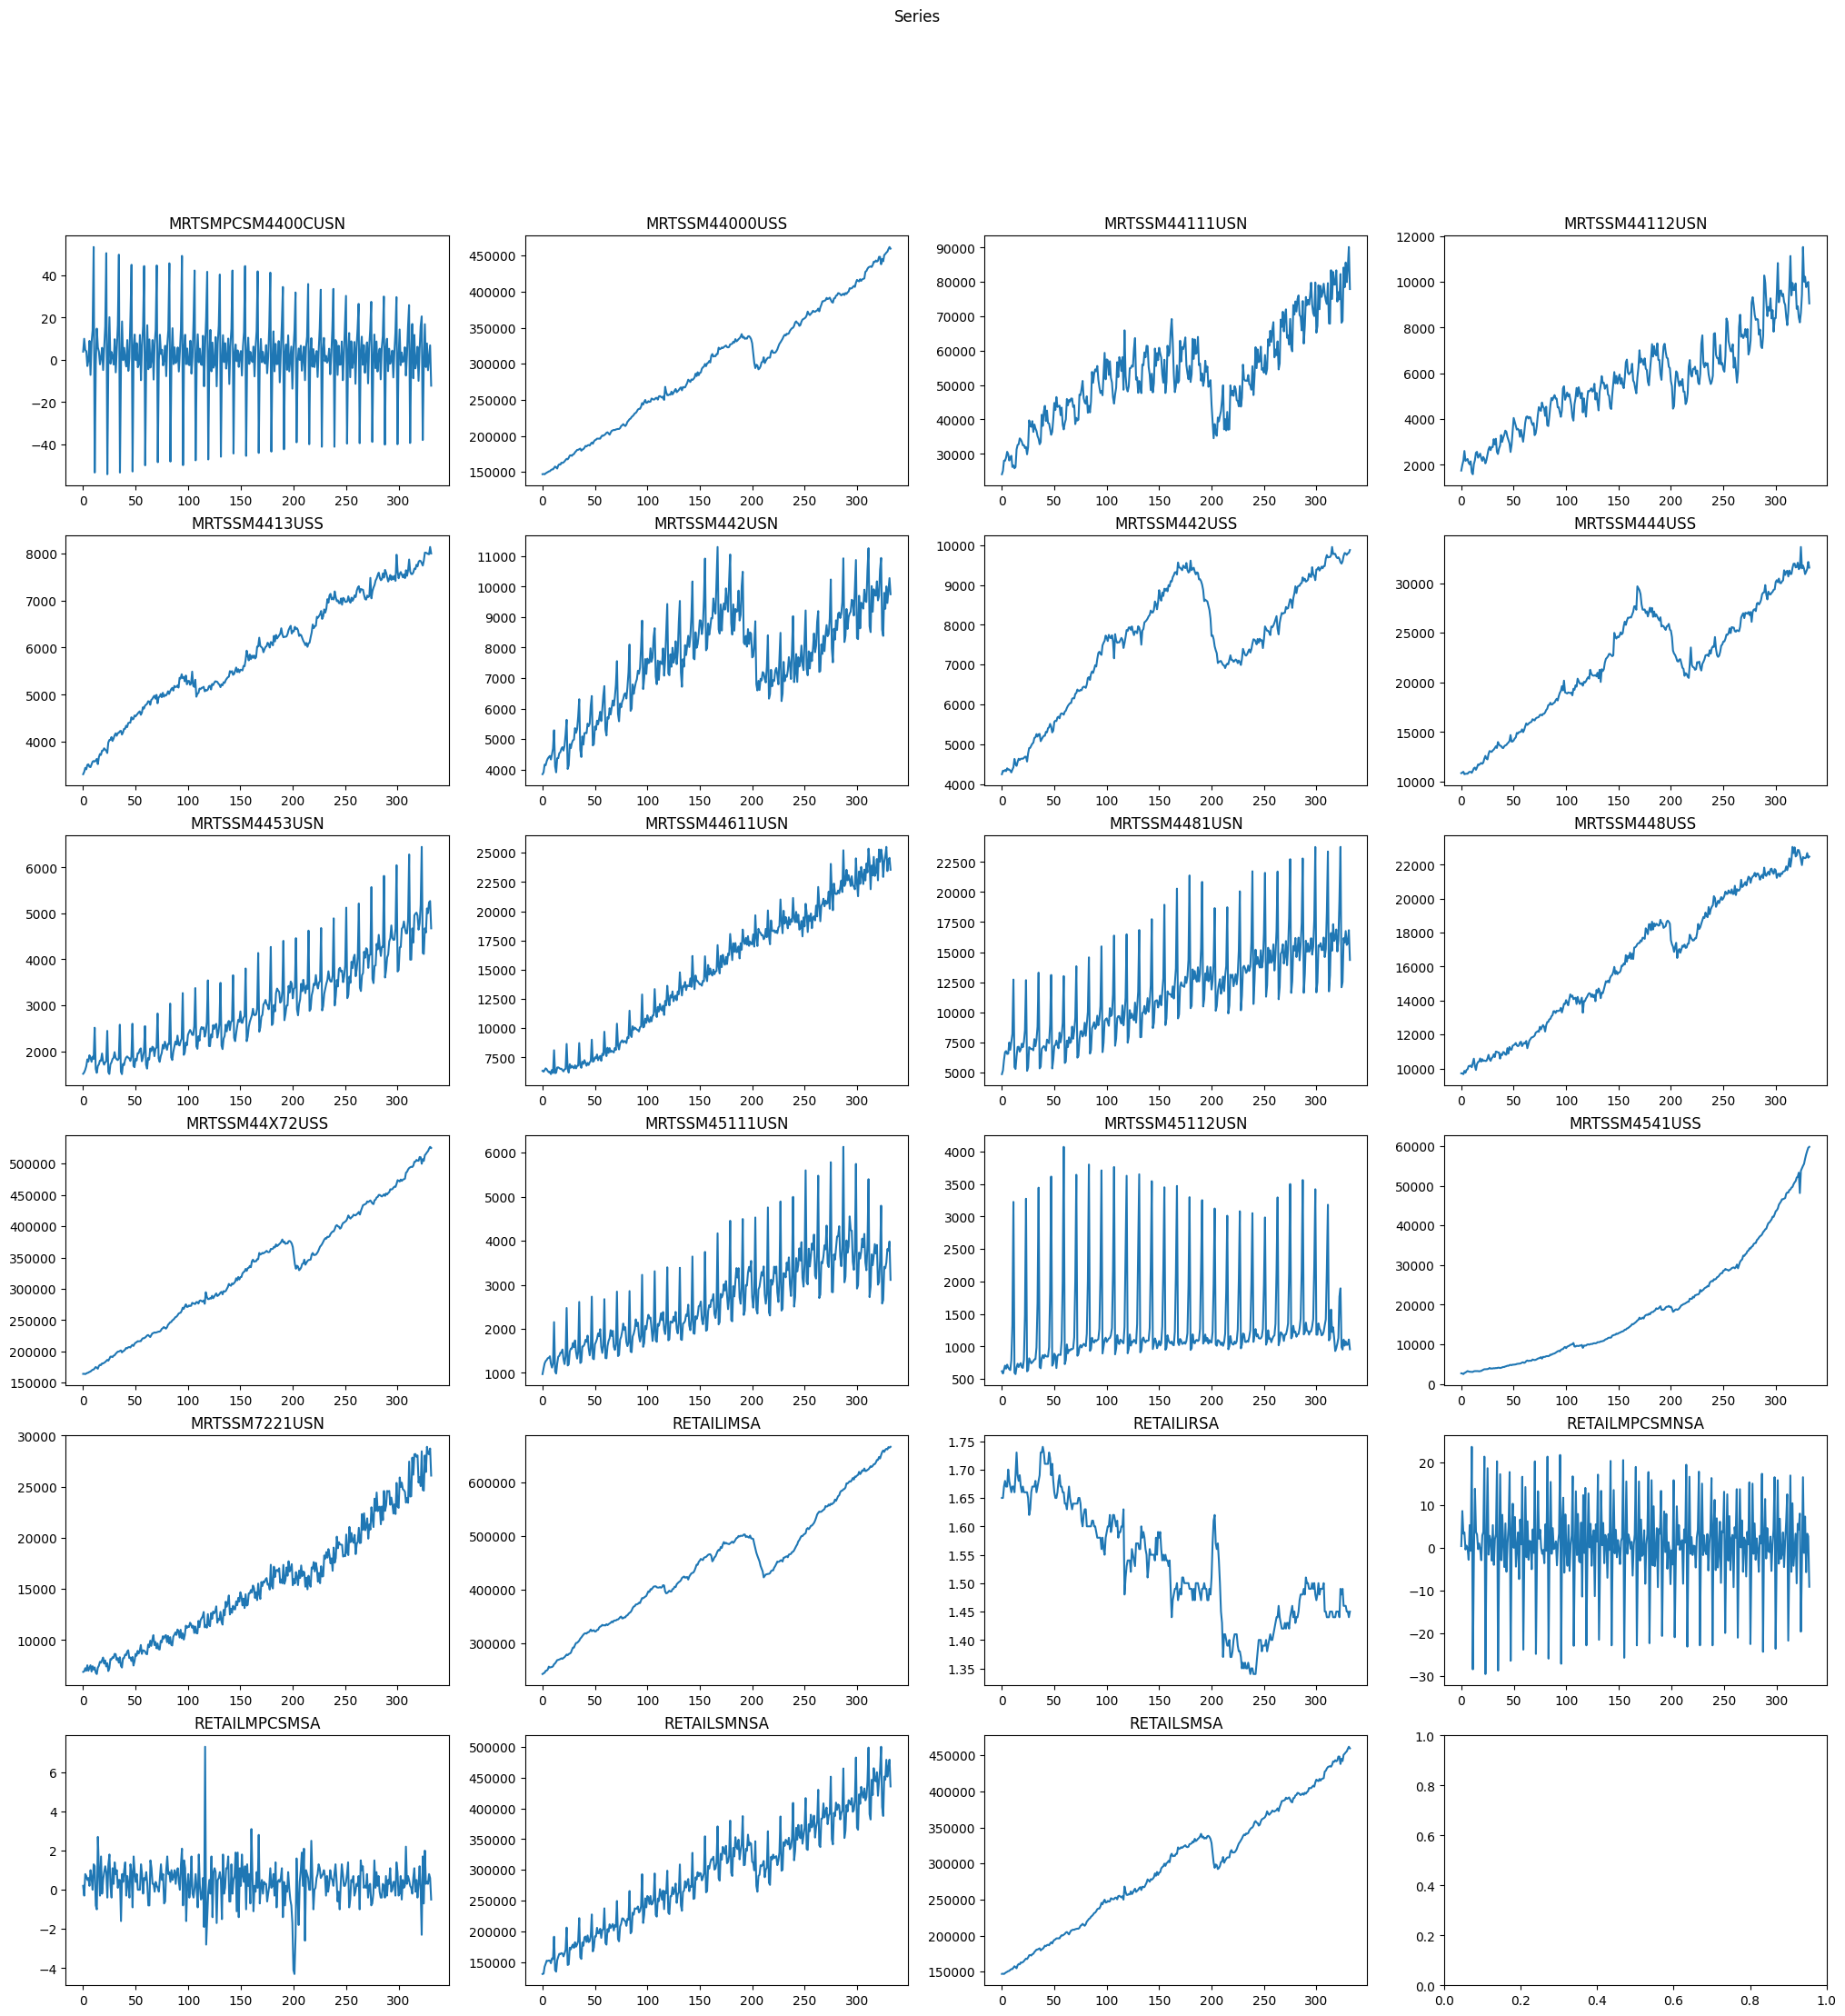

In [6]:
%matplotlib inline

fig, axs = plt.subplots(6,4,figsize=(25,25))
fig.suptitle('Series')
for i in range(6):
    for j in range(4):
        if i*4+j+1>len(mySeries): # pass the others that we can't fill
            continue
        axs[i, j].plot(mySeries[i*4+j].values)
        axs[i, j].set_title(namesofMySeries[i*4+j])
plt.show()

##Data processing

In [7]:
series_lengths = {len(series) for series in mySeries}
print(series_lengths)

{332, 333}


In [8]:
ind = 0
for series in mySeries:
    print("["+str(ind)+"] "+series.index[0]+" "+series.index[len(series)-1])
    ind+=1

[0] 1992-02-01 2019-09-01
[1] 1992-01-01 2019-09-01
[2] 1992-01-01 2019-09-01
[3] 1992-01-01 2019-09-01
[4] 1992-01-01 2019-09-01
[5] 1992-01-01 2019-09-01
[6] 1992-01-01 2019-09-01
[7] 1992-01-01 2019-09-01
[8] 1992-01-01 2019-09-01
[9] 1992-01-01 2019-09-01
[10] 1992-01-01 2019-09-01
[11] 1992-01-01 2019-09-01
[12] 1992-01-01 2019-09-01
[13] 1992-01-01 2019-09-01
[14] 1992-01-01 2019-09-01
[15] 1992-01-01 2019-09-01
[16] 1992-01-01 2019-09-01
[17] 1992-01-01 2019-09-01
[18] 1992-01-01 2019-09-01
[19] 1992-02-01 2019-09-01
[20] 1992-02-01 2019-09-01
[21] 1992-01-01 2019-09-01
[22] 1992-01-01 2019-09-01


In [9]:
max_len = max(series_lengths)
longest_series = None
for series in mySeries:
    if len(series) == max_len:
        longest_series = series

In [10]:
longest_series

,value
date,
1992-01-01,146925
1992-02-01,147223
1992-03-01,146805
1992-04-01,148032
1992-05-01,149010
...,...
2019-05-01,454135
2019-06-01,455546
2019-07-01,458974


In [11]:
problems_index = []

for i in range(len(mySeries)):
    if len(mySeries[i])!= max_len:
        problems_index.append(i)
        mySeries[i] = mySeries[i].reindex(longest_series.index)

print(problems_index)

[0, 19, 20]


In [12]:
def nan_counter(list_of_series):
    nan_polluted_series_counter = 0
    for series in list_of_series:
        if series.isnull().sum().sum() > 0:
            nan_polluted_series_counter+=1
    print(nan_polluted_series_counter)

In [13]:
mySeries[1].shape

(333, 1)

In [14]:
for i in problems_index:
    mySeries[i].interpolate(limit_direction="both",inplace=True)

In [15]:
nan_counter(mySeries)

0


Max-Min normalization is computed as
$$
x-x_{min}/x_{max}-x_{min}
$$
So after normalization the value is between 0 and 1

In [16]:
for i in range(len(mySeries)):
    scaler = MinMaxScaler()
    mySeries[i] = MinMaxScaler().fit_transform(mySeries[i])
    mySeries[i]= mySeries[i].reshape(len(mySeries[i]))

In [17]:
print("max: "+str(max(mySeries[0]))+"\tmin: "+str(min(mySeries[0])))
print(mySeries[0][:5])


max: 1.0	min: 0.0
[0.53953488 0.53953488 0.59627907 0.54697674 0.54139535]


##Time series Kmeans

In [18]:
cluster_count = math.ceil(math.sqrt(len(mySeries)))
# A good rule of thumb is choosing k as the square root of the number of points in the training data set in kNN

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(mySeries)

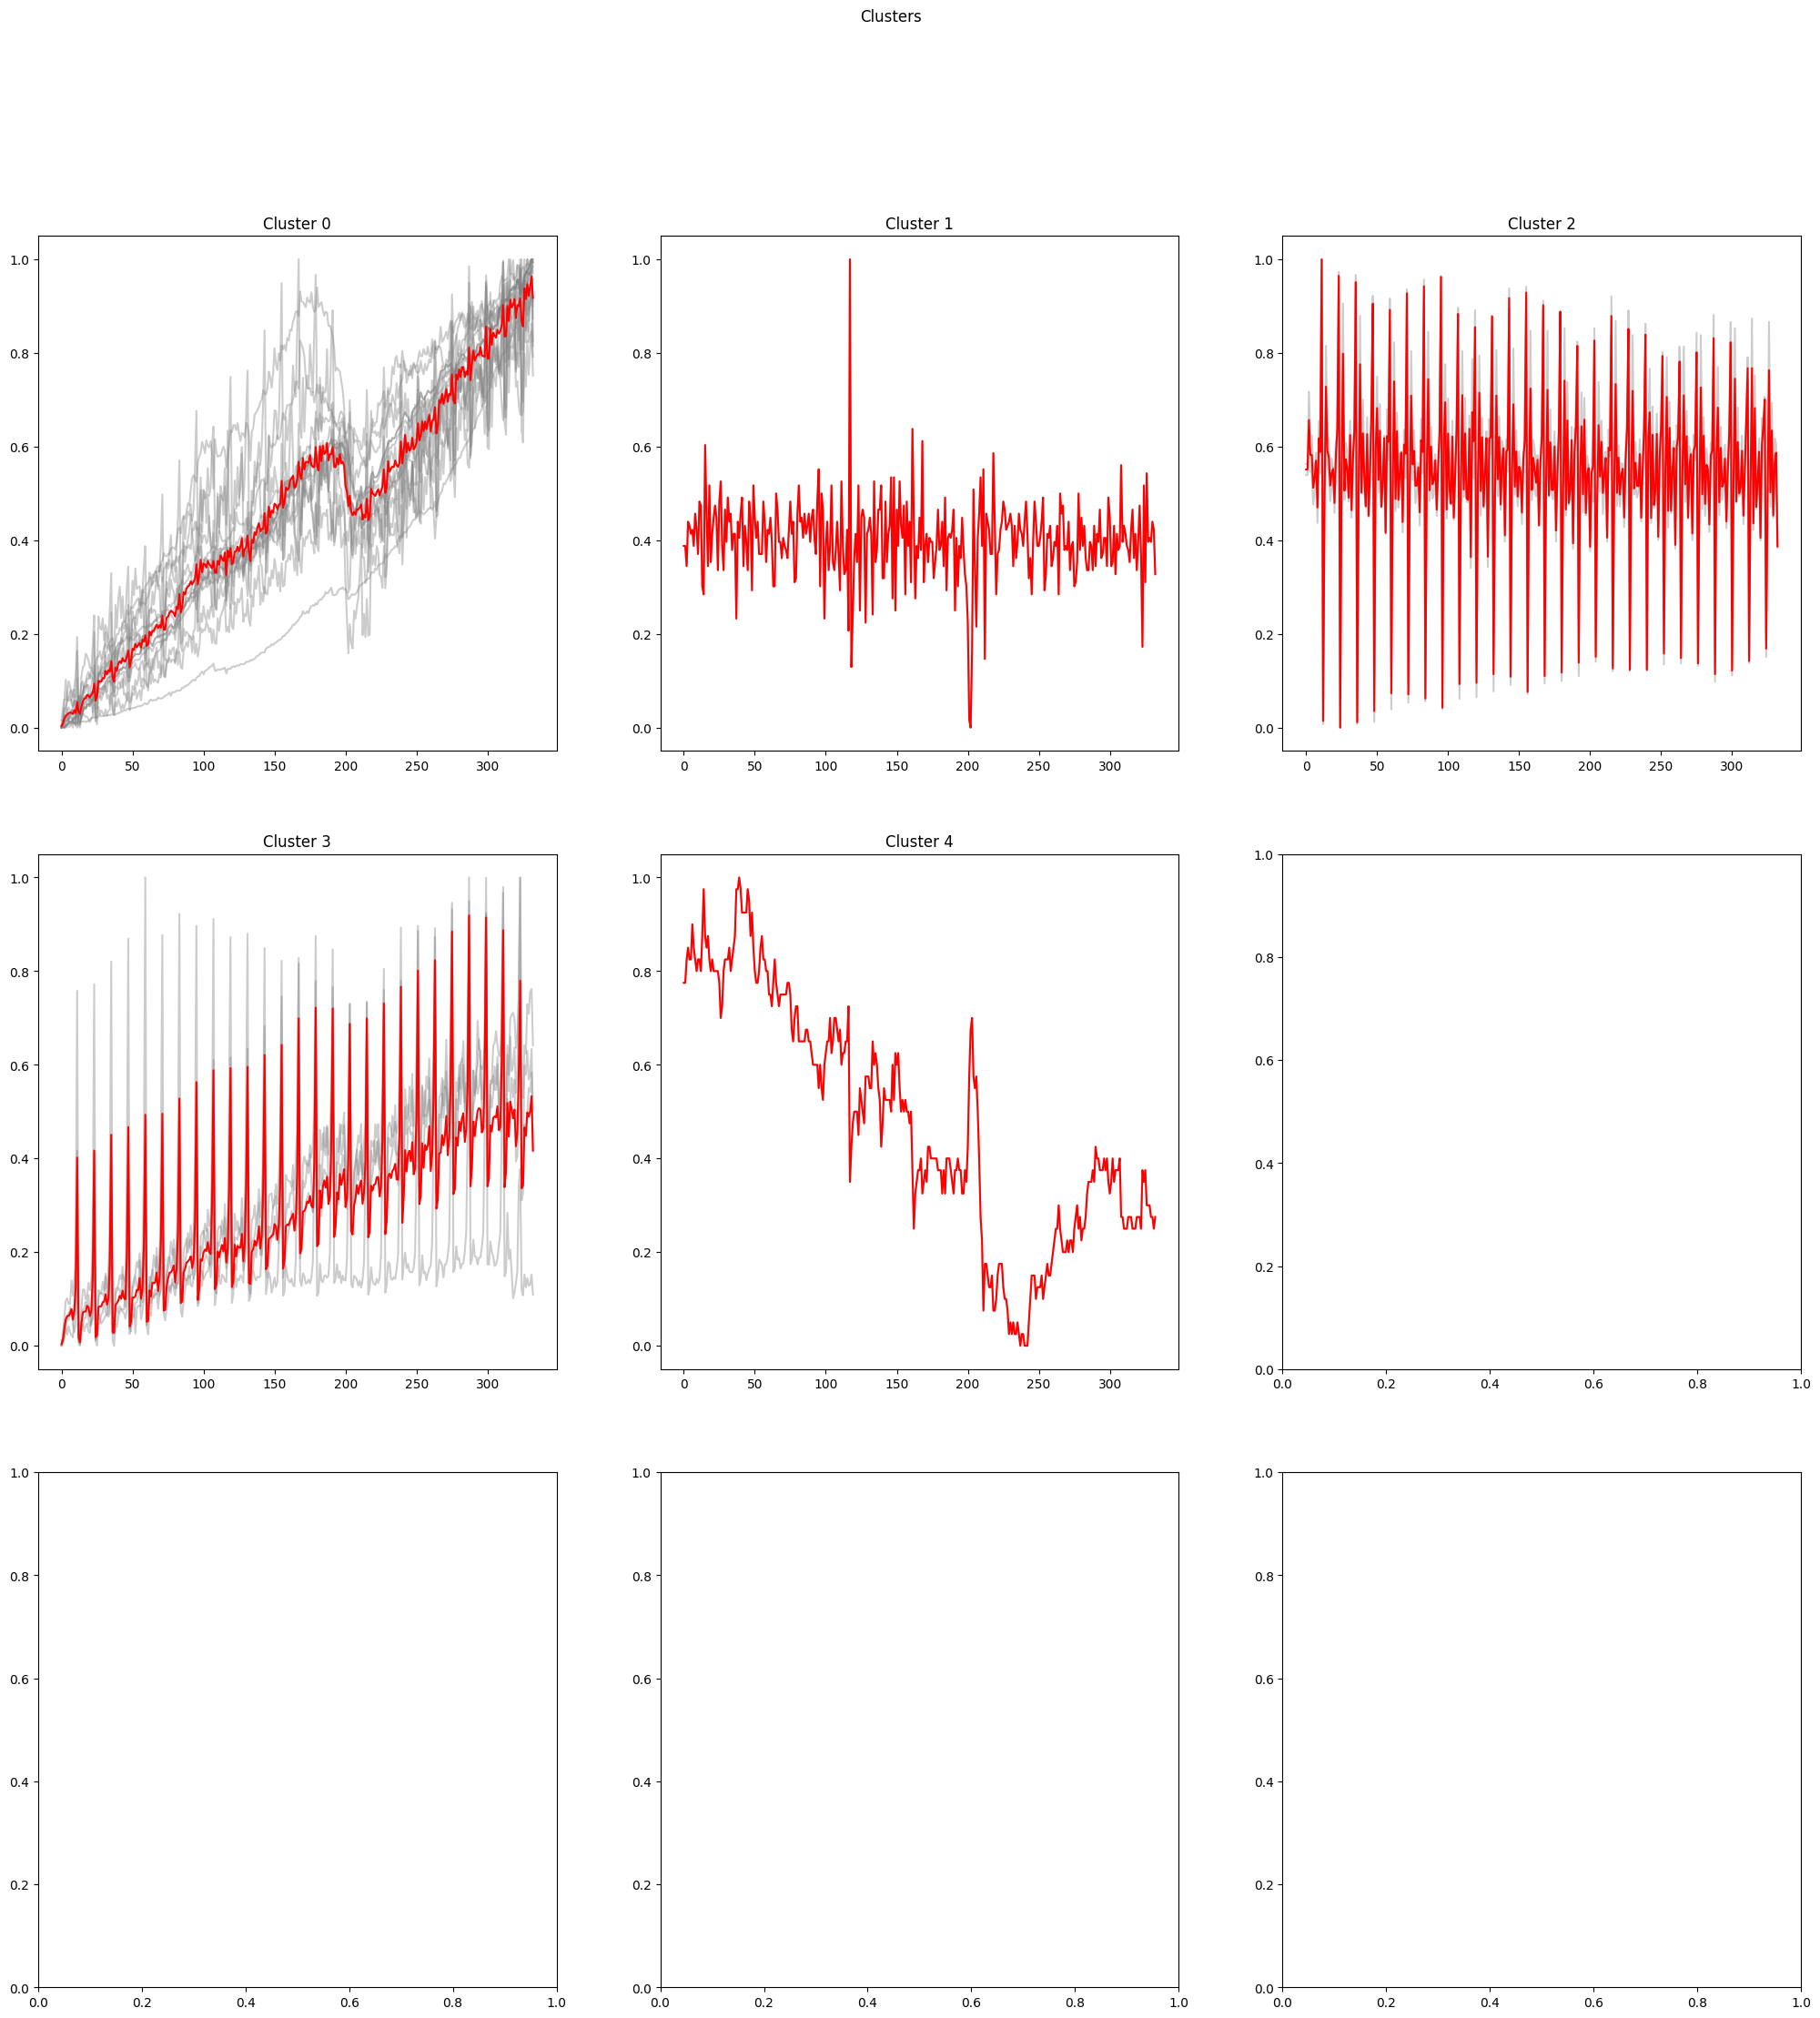

In [19]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(mySeries))))

plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0

plt.show()

In [20]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
MRTSSM448USS,Cluster 0
RETAILIMSA,Cluster 0
MRTSSM7221USN,Cluster 0
MRTSSM4541USS,Cluster 0
MRTSSM44X72USS,Cluster 0
RETAILSMNSA,Cluster 0
MRTSSM44611USN,Cluster 0
RETAILSMSA,Cluster 0
MRTSSM442USS,Cluster 0


In [21]:
kmeans = KMeans(n_clusters=cluster_count,max_iter=5000)

labels_kmeans = kmeans.fit_predict(mySeries)

c:\Users\fa028\GitHub\Time-Series\venv\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [22]:
labels_kmeans


array([3, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 2, 4, 2, 2, 0, 1, 3, 1, 0,
       0])

In [23]:
fancy_names_for_labels = [f"Cluster {label}" for label in labels_kmeans]
pd.DataFrame(zip(namesofMySeries,fancy_names_for_labels),columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

,Cluster
Series,
MRTSSM448USS,Cluster 0
RETAILIMSA,Cluster 0
MRTSSM44X72USS,Cluster 0
RETAILSMNSA,Cluster 0
MRTSSM44611USN,Cluster 0
MRTSSM444USS,Cluster 0
RETAILSMSA,Cluster 0
MRTSSM442USN,Cluster 0
MRTSSM4413USS,Cluster 0


In [24]:
# prompt: compute Silhouette for km

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
silhouette_score(mySeries, labels, metric="euclidean")


0.41126073880988595

In [29]:
from tslearn.clustering import silhouette_score

silhouette_score(mySeries, labels, metric="dtw")

0.49824630837644973

In [25]:
silhouette_score(mySeries, labels_kmeans, metric="euclidean")

0.3685021910827548

In [26]:
calinski_harabasz_score(mySeries, labels)

12.560104984249222

In [27]:
calinski_harabasz_score(mySeries, labels_kmeans)

14.915299854314155

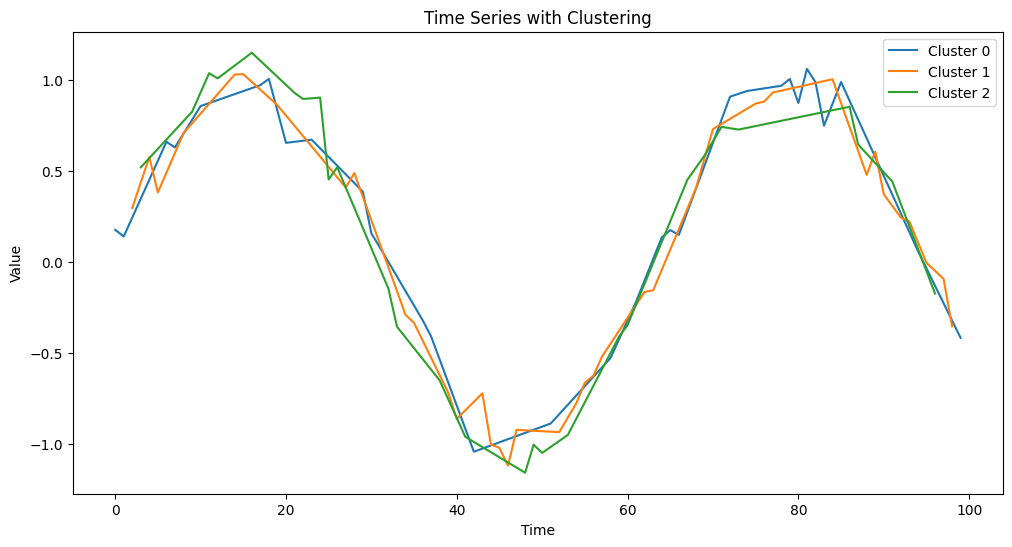

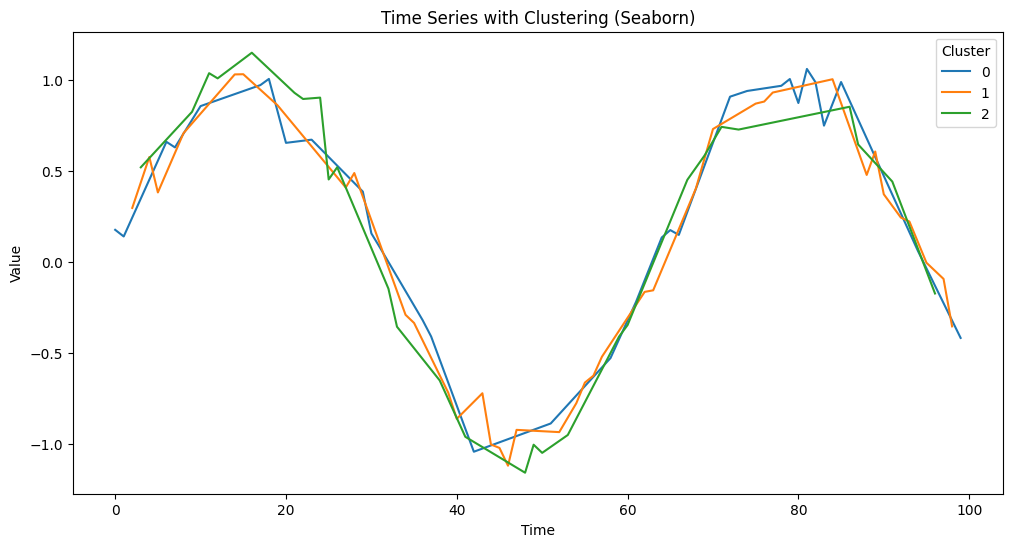

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample data creation
np.random.seed(0)
time = np.arange(0, 100, 1)  # Time series (0 to 100)
values = np.sin(time / 10) + np.random.normal(0, 0.1, time.shape[0])  # Sinusoidal values with noise
clusters = np.random.randint(0, 3, time.shape[0])  # Random clusters (0, 1, 2)

# Creating a DataFrame for ease of use
df = pd.DataFrame({
    'Time': time,
    'Value': values,
    'Cluster': clusters
})

# Plotting using matplotlib
plt.figure(figsize=(12, 6))

# Plot each cluster with a different color
for cluster in np.unique(clusters):
    cluster_data = df[df['Cluster'] == cluster]
    plt.plot(cluster_data['Time'], cluster_data['Value'], label=f'Cluster {cluster}')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Clustering')
plt.legend()

# Show the plot
plt.show()

# Alternatively, plotting using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='Time', y='Value', hue='Cluster', data=df, palette='tab10')

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time Series with Clustering (Seaborn)')

# Show the plot
plt.show()
